In [30]:
import json
import sys
from copy import deepcopy
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from s4hci.utils.data_handling import load_adi_data, save_as_fits
from s4hci.models.psf_subtraction import S4
from s4hci.models.noise import S4Noise
from s4hci.utils.logging import print_message, setup_logger
from s4hci.utils.frame_selection import mse_frame_selection, \
    shift_frame_selection

from applefy.utils.file_handling import open_fits
from applefy.utils.fake_planets import add_fake_planets

# Load the data

In [2]:
# 2.) Load the dataset
print_message("Loading dataset")
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset="/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5",
        data_tag="object",  #13_object_final
        psf_template_tag="psf_template", #10_psf
        para_tag="header_object/PARANG")

science_data = science_data[:, 12:-12, 12:-12]

# Background subtraction of the PSF template
psf_template_data = np.median(raw_psf_template_data, axis=0)
psf_template_data = psf_template_data - np.min(psf_template_data)

In [3]:
fake_planet_config_file = "/fast/mbonse/s4/70_results/07_partial_contrast_grid/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_0105c.json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

In [4]:
data_with_fake_planet_cut = data_with_fake_planet[:, 30:-30, 30:-30]
science_cut = science_data[:, 30:-30, 30:-30]
angles_cut = raw_angles

# Build S4 models

In [37]:
s4_model_trained_on_planet = S4(
    science_data=deepcopy(data_with_fake_planet_cut[:, ::-1, ::-1]),
    parang=angles_cut,
    psf_template=psf_template_data,
    noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_normalization="normal",
    noise_lambda_init=1e4,
    planet_convolve_second=False,
    planet_use_up_sample=1,
    work_dir="/fast/mbonse/s4/70_results/08_train_jointly/01_0105c/strong_regularization",
    convolve=True,
    verbose=True)

s4_model_trained_on_planet.find_closed_form_noise_model(fp_precision="float32")

S4 model: finding closed form noise model ... S4 Noise: fitting noise model ... Fitting ... 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3249/3249 [01:32<00:00, 35.31it/s]


[DONE]
[DONE]
[DONE]


In [22]:
s4_model_trained_on_raw = S4(
    science_data=science_cut,
    parang=angles_cut,
    psf_template=psf_template_data,
    noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_normalization="normal",
    noise_lambda_init=1e8,
    planet_convolve_second=False,
    planet_use_up_sample=1,
    work_dir="/fast/mbonse/s4/70_results/08_train_jointly/01_0105c/strong_regularization",
    convolve=True,
    verbose=True)

s4_model_trained_on_raw.find_closed_form_noise_model(fp_precision="float32")

S4 model: finding closed form noise model ... S4 Noise: fitting noise model ... Fitting ... 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3249/3249 [01:32<00:00, 35.31it/s]


[DONE]
[DONE]
[DONE]


# Compute the residuals

In [38]:
import torch

In [39]:
model = s4_model_trained_on_planet
model.science_data = torch.from_numpy(data_with_fake_planet_cut).float()
planet_residual_trained_on_planet = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

model.science_data = torch.from_numpy(science_cut).float()
raw_residual_trained_on_planet = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

S4 model: computing residual ... [DONE]
S4 model: computing residual ... [DONE]


In [25]:
model = s4_model_trained_on_raw
model.science_data = torch.from_numpy(data_with_fake_planet_cut).float()
planet_residual_trained_on_raw = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

model.science_data = torch.from_numpy(science_cut).float()
raw_residual_trained_on_raw = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

S4 model: computing residual ... [DONE]
S4 model: computing residual ... [DONE]


# Plot the results

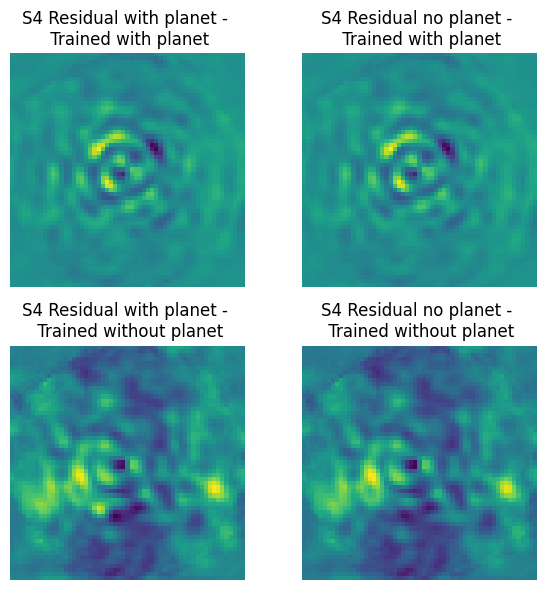

In [40]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(6,6))

ax1.imshow(planet_residual_trained_on_planet, origin="lower")#, vmin=-0.02, vmax=0.02)
ax2.imshow(raw_residual_trained_on_planet, origin="lower")#, vmin=-0.02, vmax=0.02)
ax3.imshow(planet_residual_trained_on_raw, origin="lower")#, vmin=-0.02, vmax=0.02)
ax4.imshow(raw_residual_trained_on_raw, origin="lower")#, vmin=-0.02, vmax=0.02)

ax1.axis("off")
ax1.set_title("S4 Residual with planet - \n Trained with planet")
ax2.axis("off")
ax2.set_title("S4 Residual no planet - \n Trained with planet")
ax3.axis("off")
ax3.set_title("S4 Residual with planet - \n Trained without planet")
ax4.axis("off")
ax4.set_title("S4 Residual no planet - \n Trained without planet")
plt.tight_layout()

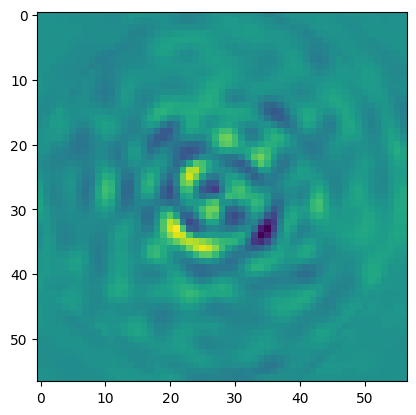

In [41]:
plt.imshow(planet_residual_trained_on_planet - planet_residual_trained_on_raw)